# Session: Face Swap

1. Select any two person image with front face.
2. It finds 68 points landmarks for both the faces using DLIB
3. It finds Convex Hull from second image and calculate mask for seamless cloning
4. It find Delaunay traingulation for convex hull points for both the images
5. Finally, it apply affine transformation to Delaunay triangles and perform clone seamlessly

Source: https://github.com/spmallick/PyImageConf2018/blob/master/FaceSwap.ipynb

In [1]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA4_Phase2/session3/notebooks')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA4_Phase2/session3/notebooks


In [4]:
# Import modules
import sys, cv2,dlib, time
import numpy as np
import faceBlendCommon as fbc
import matplotlib.pyplot as plt

In [5]:
print(f'dlib: {dlib.__version__}')
print(f'cv2: {cv2.__version__}')

dlib: 19.18.0
cv2: 4.1.2


In [7]:
# To autoreload all te custom files when modified
import autoreload
%load_ext autoreload
%autoreload

In [8]:
# Landmark model location
DATA_PATH = './test_images'
RESULTS_PATH = './results'
MODEL_PATH = './predictor'
PREDICTOR_PATH = f'{MODEL_PATH}/shape_predictor_68_face_landmarks.dat'

In [9]:
# Download landmarks data file
if os.path.exists(PREDICTOR_PATH)==False:
  !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
  !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
else:
  print(f'model file {PREDICTOR_PATH} already exists..')

model file ./predictor/shape_predictor_68_face_landmarks.dat already exists..


In [10]:
# Read images
img1 = cv2.imread(f'{DATA_PATH}/amit.jpg')
img2 = cv2.imread(f'{DATA_PATH}/arvind.jpg')

im1Display = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
im2Display = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img1Warped = np.copy(img2)

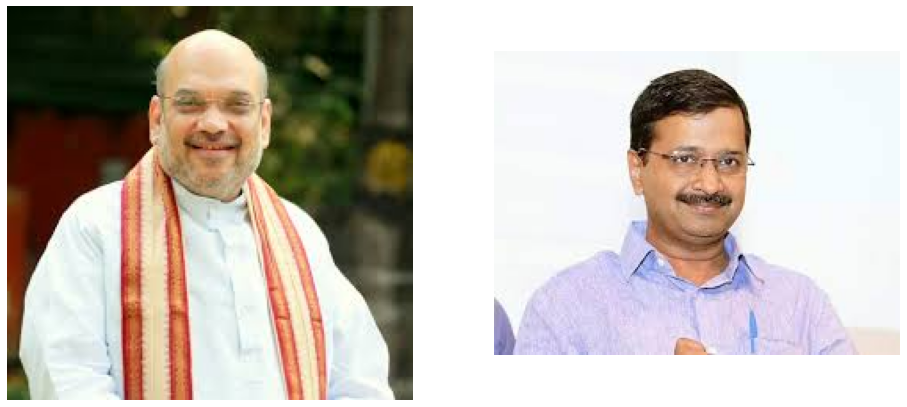

In [11]:
# Display Images 
plt.figure(figsize = (16,8))
plt.subplot(121); plt.imshow(im1Display); plt.axis('off');
plt.subplot(122); plt.imshow(im2Display); plt.axis('off');

In [12]:
# Initialize the dlib facial landmakr detector
detector = dlib.get_frontal_face_detector()

# Initialize the Landmark Predictor (a.k.a. shape predictor). The landmark detector is implemented in the shape_predictor class
predictor = dlib.shape_predictor(PREDICTOR_PATH)

# Read array of corresponding points
points1 = fbc.getLandmarks(detector, predictor, img1)
points2 = fbc.getLandmarks(detector, predictor, img2)

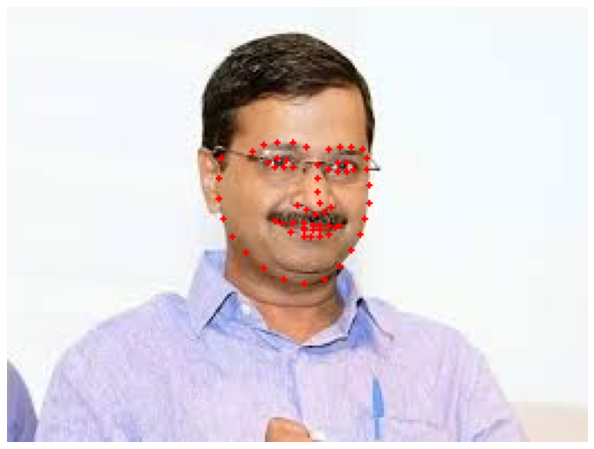

In [13]:
# Display Landmarks
imTemp = im2Display.copy()
for p in points2:
    cv2.circle(imTemp, p, 1, (255,0,0), -1) 

plt.figure(figsize = (16,8)); plt.imshow(imTemp); plt.axis('off');

In [14]:
# Find convex hull
hullIndex = cv2.convexHull(np.array(points2), returnPoints=False)

# Create convex hull lists
hull1 = []
hull2 = []
for i in range(0, len(hullIndex)):
    hull1.append(points1[hullIndex[i][0]])
    hull2.append(points2[hullIndex[i][0]])

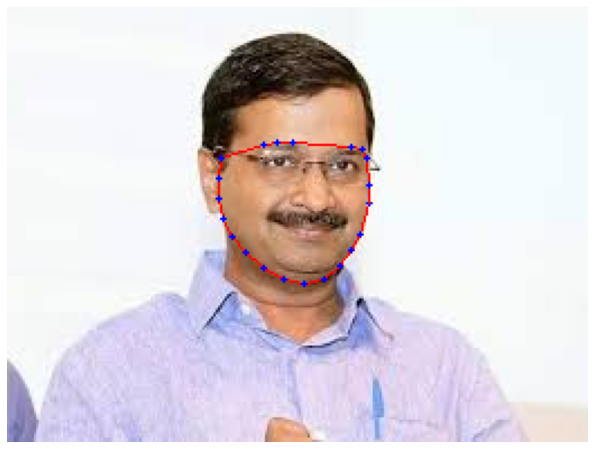

In [15]:
# Display Convex Hull
imTemp = im2Display.copy()
numPoints = len(hull2)
for i in range(0, numPoints):
    cv2.line(imTemp, hull2[i], hull2[(i+1)%numPoints], (255,0,0), 1)
    cv2.circle(imTemp, hull2[i], 1, (0,0,255), -1)
plt.figure(figsize = (16, 8)); plt.imshow(imTemp); plt.axis('off');

In [16]:
# Calculate Mask for Seamless cloning
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))

mask = np.zeros(img2.shape, dtype=img2.dtype) 
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

# Find Centroid
m = cv2.moments(mask[:,:,1])
center = (int(m['m10']/m['m00']), int(m['m01']/m['m00']))

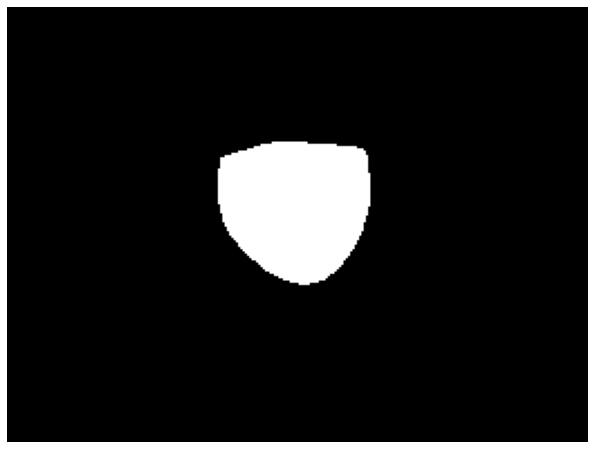

In [17]:
# Display Mask
plt.figure(figsize = (16,8)); plt.imshow(mask); plt.axis('off');

In [18]:
# Find Delaunay traingulation for convex hull points
sizeImg2 = img2.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])

dt = fbc.calculateDelaunayTriangles(rect, hull2)

# If no Delaunay Triangles were found, quit
if len(dt) == 0:
    quit()

In [19]:
imTemp1 = im1Display.copy()
imTemp2 = im2Display.copy()

tris1 = []
tris2 = []
for i in range(0, len(dt)):
    tri1 = []
    tri2 = []
    for j in range(0, 3):
        tri1.append(hull1[dt[i][j]])
        tri2.append(hull2[dt[i][j]])

    tris1.append(tri1)
    tris2.append(tri2)

cv2.polylines(imTemp1,np.array(tris1),True,(0,0,255),1);
cv2.polylines(imTemp2,np.array(tris2),True,(0,0,255),1);

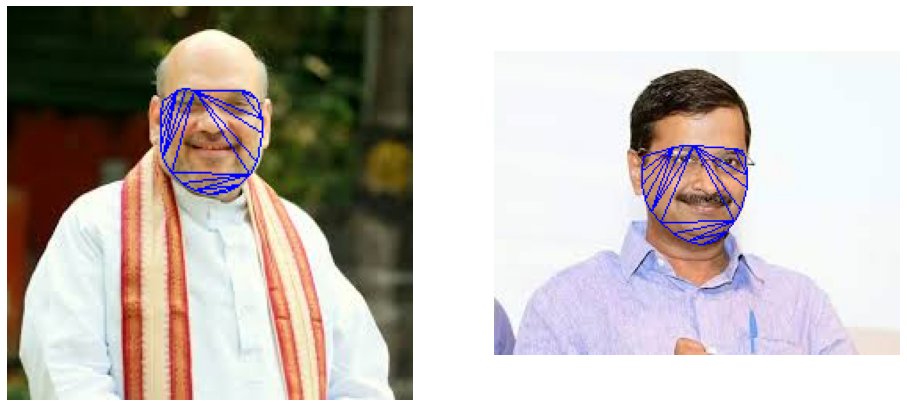

In [20]:
# Display Triangulation
plt.figure(figsize = (16,8)); 
plt.subplot(121); plt.imshow(imTemp1); plt.axis('off');
plt.subplot(122); plt.imshow(imTemp2); plt.axis('off');

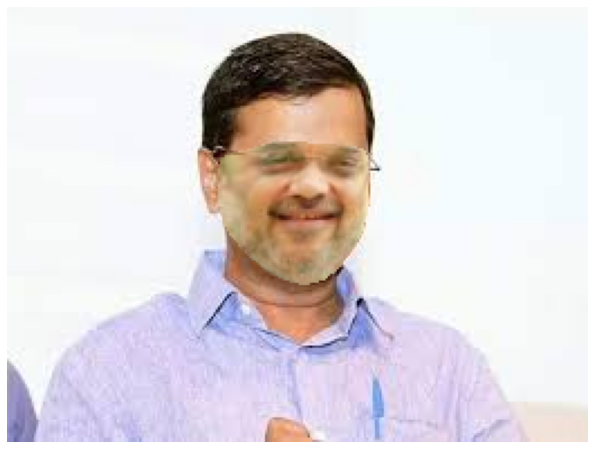

In [21]:
# Simple Alpha Blending
# Apply affine transformation to Delaunay triangles
for i in range(0, len(tris1)):
    fbc.warpTriangle(img1, img1Warped, tris1[i], tris2[i])

plt.figure(figsize=(16,8));
plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');

In [22]:
# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)

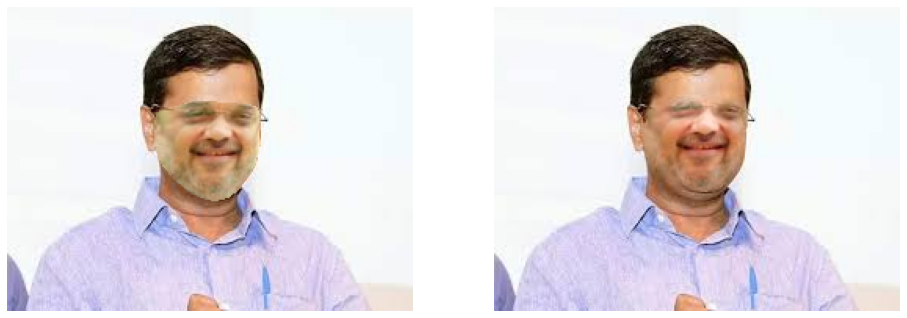

In [23]:
plt.figure(figsize=(16,8))
plt.subplot((121)); plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');
plt.subplot((122)); plt.imshow(output[:,:,::-1]); plt.axis('off');

### Numpy image to base64 format to transfer swap images in REST API

In [36]:
from PIL import Image
import io
import base64

def img_to_base64(img):
    img = Image.fromarray(img, 'RGB') 
    buffer = io.BytesIO()
    img.save(buffer,format="JPEG")
    myimage = buffer.getvalue()                     
    img_str = f"data:image/jpeg;base64,{base64.b64encode(myimage).decode()}"
    return img_str
    
output_base64 = img_to_base64(output)

''
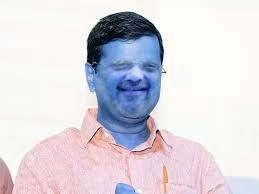

In [38]:
# This will be send to Web App for rendering on HTML page
output_base64

### Creating Base64 Test samples for API testing

In [39]:
img1 = cv2.imread(f'{DATA_PATH}/amit.jpg')
img2 = cv2.imread(f'{DATA_PATH}/arvind.jpg')

In [40]:
img1_str = img_to_base64(img1).split(',')[1]
img2_str = img_to_base64(img2).split(',')[1]

In [41]:
img1_str

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCADdAOQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDwkCgLRRiszEdtpVWmgUooAlqL+OlJpN1MRYVfkoUUiNTg1UyCVJKcwqIVIH31SZHLYFTNXbG8S0n3t91v0qofkSoA296tysJxvuamraklwm1X3Vj4qUrXR6H4C8R+JER9N0udom/5bSYRPrk4yPpmqWupSSitDDt1+6lXXtE

In [42]:
img2_str

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCADCAQMDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3jFFOopANop1FADaKdijFAxKKXFNxQFwooxRigBc0uaSkpWGOzRmm1n6rrelaJB5+qahbWafw+dIBn6Dqfwp2Fc0aK891D4w+G7T/AI9ftl5/00jj2J+bYJ/AGsOT437322+kRf7PmXX3h9Nop+zZPOj1+mYryax+NaO6/bd

In [44]:
img_bytes1 = base64.b64decode(img1_str)
img1 = Image.open(io.BytesIO(img_bytes1))
img1 = np.array(img1)

img_bytes2 = base64.b64decode(img2_str)
img2 = Image.open(io.BytesIO(img_bytes2))
img2 = np.array(img2)

# Test also this variable in this notebooks to check if base64 conversion work well..